In [5]:
import torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.optim import SGD

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

# Introduction:

Our previous network model from the 'networks' project consisted of ony two independent parameters, although there were a total of 24 parameters in the two matrices. This is because $$A_2A_1=B$$ where $B$ is a $2\times 1$ matrix. So really, our function was $f(x)=Bx$.

The crux of Machine Learning are the Activation Functions, which add ever-so-slight non-linearities to a sequence of matrix transformations.

We'll consider instead of our previous model $$g(x)=A_2R(A_1x)$$ where $R$ is an elementwise operator defined as $$R(x)=\begin{cases}x & x>0 \\ 0 & x\leq 0\end{cases}$$

So $R$ is the Identity Function if $x>0$ but sets vales equal to 0 if $x\leq 0$. This is extremely close to being a linear operator, but it's not, due to the presence of nonlinearities for -ve $x$ values.

In [6]:
x = torch.tensor([[4, 6, 2, -1, 6, 2, 5], [1, 6, 2, -6, 5, -3, 5]])
x

tensor([[ 4,  6,  2, -1,  6,  2,  5],
        [ 1,  6,  2, -6,  5, -3,  5]])

In [7]:
R = nn.ReLU()
R(x)

tensor([[4, 6, 2, 0, 6, 2, 5],
        [1, 6, 2, 0, 5, 0, 5]])

Another example:

Text(0.5, 0, '$x$')

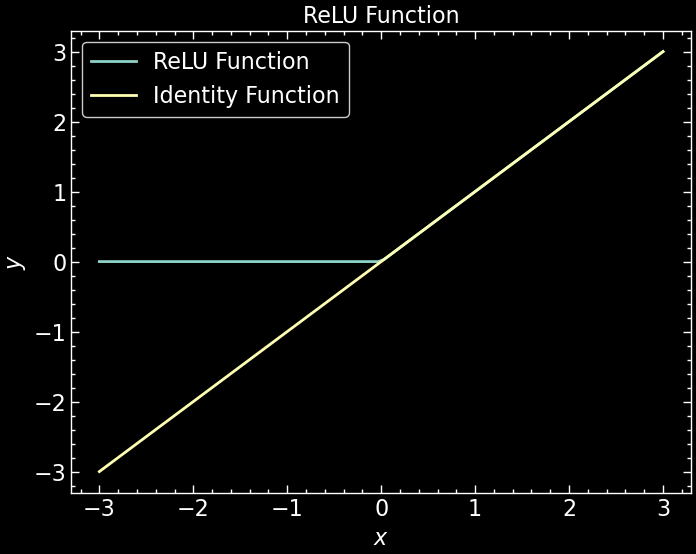

In [14]:
x = torch.linspace(-3, 3, 100)
y = R(x)

plt.plot(x.numpy(), y.numpy(), label = 'ReLU Function')
plt.plot(x, x, label = 'Identity Function')
plt.grid()
plt.legend()

plt.title('ReLU Function')
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')

Comparing against our old model:

In [15]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(2, 8, bias = False)
        self.Matrix2 = nn.Linear(8, 1, bias = False)
        
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)

        return x.squeeze()

# Training the model:

In [20]:
def train_model(x, y, g, n_epochs = 50):
    opt = SGD(g.parameters(), lr = 0.001)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()

        loss_value = L(g(x), y)
        loss_value.backward()

        opt.step()
        losses.append(loss_value.item())

    return g, losses

In [21]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

g = MyNeuralNetwork()
g, losses = train_model(x, y, g, n_epochs = 5000)

In [22]:
y, g(x)

(tensor([1., 5., 2., 5.]),
 tensor([2.7139, 2.6232, 1.8229, 5.2805], grad_fn=<SqueezeBackward0>))

Slightly better. The real advantage of this nonlinearity is that we can make our matrices much larger. This only works because of our Nonlinearity Function $R(x)$. Without it, we would just have $$A_2A_1=B$$ and so $f(x)=B$ where $B$ is still in lower dimensions while $A_1$ and $A_2$ would've gotten larger. This function, to some extent, makes all the parameters independent of each other. Let's consider another model $$h(x)=A_2R(A_1x)$$ where $A_1$ and $A_2$ are $80\times 2$ and $1\times 80$ respectively.

In [23]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(2, 80, bias = False)
        self.Matrix2 = nn.Linear(80, 1, bias = False)
        
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)

        return x.squeeze()

In [24]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

h = MyNeuralNetwork()
h, losses = train_model(x, y, h, n_epochs = 5000)

In [26]:
y, h(x)

(tensor([1., 5., 2., 5.]),
 tensor([1.9338, 3.6813, 1.8961, 5.1934], grad_fn=<SqueezeBackward0>))

Getting closer, but still not exact. We can introduce other parameters to optimize our model: $$i(x)=A_2R(A_1x+b_1)+b_2$$ where the Bias Vectors $b_1$ and $b_2$ are matrices added to each linear transformations.

In [28]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(2, 80, bias = True)
        self.Matrix2 = nn.Linear(80, 1, bias = True)
        
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)

        return x.squeeze()

In [29]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

i = MyNeuralNetwork()
i, losses = train_model(x, y, i, n_epochs = 5000)

In [30]:
y, i(x)

(tensor([1., 5., 2., 5.]),
 tensor([1.4429, 4.4271, 2.0120, 5.0455], grad_fn=<SqueezeBackward0>))

Better, but still not getting us that close. We'll add another matrix in the middle: $$j(x)=A_3R[A_2R(A_1x+b_1)+b_2]$$ where $A_1$, $A_2$ and $A_3$ are $80\times 2$, $80\times 80$ and $1\times 80$ respectively.

In [34]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.Matrix1 = nn.Linear(2, 80, bias = True)
        self.Matrix2 = nn.Linear(80, 80, bias = True)
        self.Matrix3 = nn.Linear(80, 1, bias = True)
        
        self.R = nn.ReLU()

    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)

        return x.squeeze()

In [35]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

j = MyNeuralNetwork()
j, losses = train_model(x, y, j, n_epochs = 5000)

In [36]:
y, j(x)

(tensor([1., 5., 2., 5.]),
 tensor([1.0069, 4.9977, 2.0010, 5.0037], grad_fn=<SqueezeBackward0>))

This is predicting $y$ almost exactly, albeit by Overfitting. The model has the potential to fit these arbitrary data points, through a sequence of linear transformations, followed by slightly nonlinear ones.

# The 'Sequential' Neural Network:

A general 'Sequential' Neural Network can be expressed as $$f(x)=\xi_{i=1}^n R_i(A_ix+b_i)$$ where $\xi_{i=1}^nf_i(x)=f_n \circ f_{n-1}+\cdots \circ f_1(x)$, the $A_i$ are matrices and the $b_i$'s are the Bias Vectors. Typically the $R_i$ are the same for all layers (especially ReLU) except for the last one, where its the Identity Function.

In clever architectures, like Convolutional Neural Networks, the $A_i$'s become spare matrices (most of their parameters are fixed to equal zero).